In [2]:
import pandas as pd
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text import *
from scoping.models import *
import scoping.utils.learning_utils as lu

django.db.connection.close()

p = Project.objects.get(pk=178)
p

<Project: Regional Impacts Map>

In [3]:
df = predicted_relevance = pd.read_csv('../data/doctables/all_relevance.csv')

In [40]:
cdf = pd.read_csv('../data/category_predictions.csv')

cdf = cdf.merge(df[['id','mean_prediction','upper_pred','lower_pred']])

pred_cats = [c for c  in cdf.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(cdf[c].sum())
    label = c.replace(" - mean_prediction",'')
    cdf.loc[cdf[label]==1,c] = 1
    print(cdf[c].sum())
print(pred_cats)

attrib_cats = [c for c  in cdf.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(cdf[c].sum())
    label = c.replace(" - mean_prediction",'')
    cdf.loc[cdf[label]==1,c] = 1
    print(cdf[c].sum())
attrib_cats

1994.0
2135.833333333333
7694.166666666668
7977.833333333335
3508.5
3682.3333333333335
28089.166666666668
28527.000000000004
6168.333333333334
6409.000000000001
['12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Coastal and marine Ecosystems - mean_prediction', '12 - Terrestrial ES - mean_prediction', '12 - Human and managed - mean_prediction']
37018.0
37444.333333333336
26211.0
26536.166666666664
1869.0000000000002
1975.0000000000002


['2 - Trend or climate change attribtion - mean_prediction',
 '2 - 2.4. Sensitivity - mean_prediction',
 '2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction']

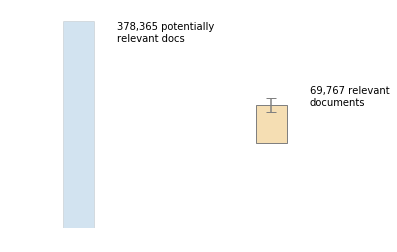

In [41]:
fig, ax = plt.subplots()

h = df.shape[0]
ax.bar(0,h,alpha=0.2,edgecolor="grey")
ax.text(1,h*0.9,f"{h:,} potentially\nrelevant docs")

nr = df.query('mean_prediction>0.5').shape[0] + df.query('relevant==1').shape[0]
ur = df.query('upper_pred>0.5').shape[0] + df.query('relevant==1').shape[0]
lr = df.query('lower_pred>0.5').shape[0] + df.query('relevant==1').shape[0]

ax.errorbar(
    5,df.shape[0]*0.5-nr*0.5+nr,
    yerr = [[nr-lr],[ur-nr]],
    capsize=5,c="grey"
)

h = df.shape[0]*0.5+nr*0.5
ax.bar(
    5,nr,bottom=df.shape[0]*0.5-nr*0.5,
    color="wheat",edgecolor="grey"
)
ax.text(6,h, f"{nr:,} relevant\ndocuments")

ax.axis("off")

ax.set_xlim(xmax=8)

plt.savefig('../plots/process_diagram/relevant.pdf',bbox_to_inches="tight")



In [42]:
ur

83651

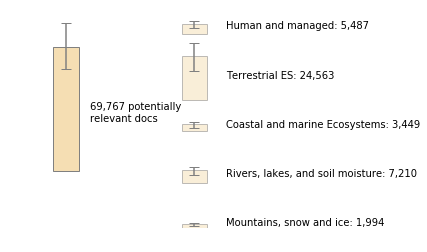

In [52]:
fig, ax = plt.subplots()
h = nr
ax.bar(0,h,color="wheat",edgecolor="grey",bottom=h*0.5)

ax.errorbar(
    0,nr*0.5+nr,
    yerr = [[nr-lr],[ur-nr]],
    capsize=5,c="grey"
)

ax.text(0.75,h*0.9,f"{h:,} potentially\nrelevant docs")
ax.set_xlim(xmax=10)
ax.axis("off")

for i,c in enumerate(pred_cats):
    n = cdf.loc[(cdf['mean_prediction']>=0.5) & (cdf[c]>=0.5)].shape[0] 
    c_actual = c.replace(' - mean_prediction','')
    
    cur = cdf.loc[(cdf['upper_pred']>=0.5) & (cdf[c.replace('mean_prediction','upper_pred')]>=0.5),].shape[0]
    clr = cdf.loc[(cdf['lower_pred']>=0.5) & (cdf[c.replace('mean_prediction','lower_pred')]>=0.5),].shape[0]
    
    n += cdf[c_actual].sum()
    bottom = i*(h*2/len(pred_cats))-n*0.5+h*0.05
    ax.bar(4, n,bottom=bottom,alpha=0.5,edgecolor="grey",color="wheat")
    ax.errorbar(4,bottom+n,yerr=[[n-clr],[cur-n]],capsize=5,c="grey")
    
    ax.text(5,bottom+n/2,f"{c.split(' - ')[1]}: {n:,.0f}" )
    
plt.savefig('../plots/process_diagram/relevant_cats.pdf')


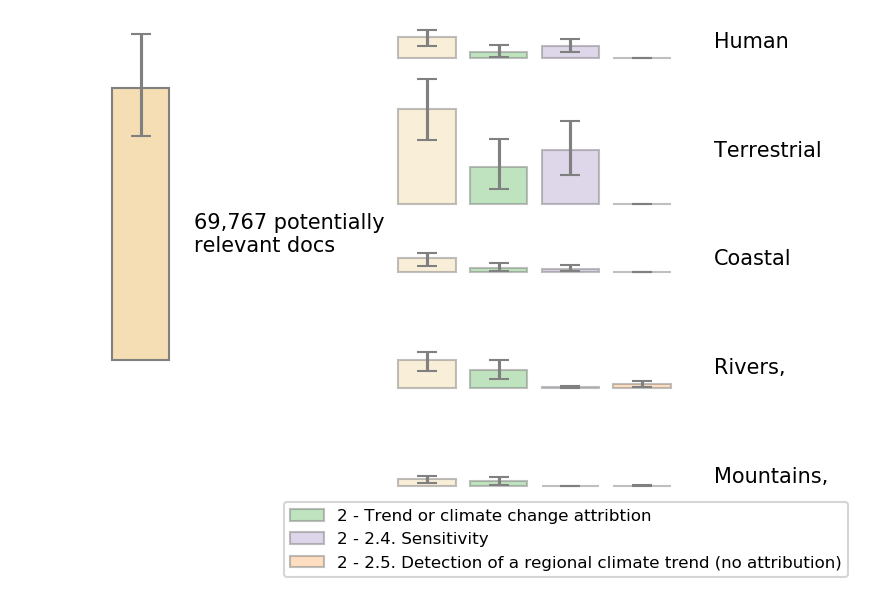

In [74]:
fig, ax = plt.subplots(dpi=150)


nr = df.query('mean_prediction>0.5').shape[0] + df.query('relevant==1').shape[0]
ur = df.query('upper_pred>0.5').shape[0] + df.query('relevant==1').shape[0]
lr = df.query('lower_pred>0.5').shape[0] + df.query('relevant==1').shape[0]
h = nr
ax.bar(0,h,color="wheat",edgecolor="grey",bottom=h*0.5)

ax.errorbar(
    0,nr*0.5+nr,
    yerr = [[nr-lr],[ur-nr]],
    capsize=5,c="grey"
)

ax.text(0.75,h*0.9,f"{h:,} potentially\nrelevant docs")
ax.set_xlim(xmax=10)
ax.set_ylim(ymin=-10000)
ax.axis("off")

colors = ['#7fc97f','#beaed4','#fdc086']

for i,c in enumerate(pred_cats):
    
    
    n = cdf.loc[(cdf['mean_prediction']>=0.5) & (cdf[c]>=0.5)].shape[0] 
    c_actual = c.replace(' - mean_prediction','')
    
    cur = cdf.loc[(cdf['upper_pred']>=0.5) & (cdf[c.replace('mean_prediction','upper_pred')]>=0.5),].shape[0]
    clr = cdf.loc[(cdf['lower_pred']>=0.5) & (cdf[c.replace('mean_prediction','lower_pred')]>=0.5),].shape[0]
    
    n += cdf[c_actual].sum()
    bottom = i*(h*2/len(pred_cats))-n*0.5+h*0.05
    ax.bar(4, n,bottom=bottom,alpha=0.5,edgecolor="grey",color="wheat")
    ax.errorbar(4,bottom+n,yerr=[[n-clr],[cur-n]],capsize=5,c="grey")
    c_actual = c.replace(' - prediction','')
    ax.text(8,bottom+n/2,f"{c.split(' - ')[1].split()[0]}" )
    
    for j, ac in enumerate(attrib_cats):
        
        n = cdf.loc[(cdf['mean_prediction']>=0.5) & (cdf[c]>=0.5) & (cdf[ac]>=0.5)].shape[0] 
        c_actual = ac.replace(' - mean_prediction','')

        acur = cdf.loc[(cdf['upper_pred']>=0.5) & (cdf[c.replace('mean_prediction','upper_pred')]>=0.5) & (cdf[ac.replace('mean_prediction','upper_pred')]>=0.5),].shape[0]
        aclr = cdf.loc[(cdf['lower_pred']>=0.5) & (cdf[c.replace('mean_prediction','lower_pred')]>=0.5) & (cdf[ac.replace('mean_prediction','lower_pred')]>=0.5),].shape[0]
        if i==0:
            ax.bar(5+j,n,bottom=bottom, color=colors[j],alpha=0.5, edgecolor="grey",label=c_actual)
        else:
            ax.bar(5+j,n,bottom=bottom, color=colors[j],alpha=0.5, edgecolor="grey")
        ax.errorbar(5+j,bottom+n,yerr=[[n-aclr],[acur-n]],capsize=5,c="grey")
        

ax.legend(fontsize=8, bbox_to_anchor=(1,0.08),ncol=1) 
fig.tight_layout()
plt.savefig('../plots/process_diagram/relevant_cats_attrib.pdf',bbox_to_inches="tight")
